# 1. Imports

In [37]:
import pandas as pd
import numpy as np
import inflection
import math


import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import HTML

import warnings
from scipy.stats import kurtosis

## 1.1. Helper Functions

In [31]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option( 'display.max_columns', None )

    sns.set_style("darkgrid")
    sns.set_palette("muted")

    warnings.filterwarnings('ignore')


In [32]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 1.2. Loading Data

In [6]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

# check
df_raw.sample(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
687206,37,3,2013-10-23,6613,732,1,1,0,1,c,a,4230.0,12.0,2014.0,0,NaN,NaN,NaN
40805,666,4,2015-06-25,4292,468,1,0,0,0,c,c,2700.0,NaN,NaN,1,9.0,2011.0,"Mar,Jun,Sept,Dec"


# 2. Data Description

In [7]:
# copy the dataset to perform some analysis
df1 = df_raw.copy()

## 2.1. Renaming Columns

In [8]:
# check the column names
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [9]:
cols_old = df1.columns
snake_case = lambda x: inflection.underscore(x)
cols_new = list( map(snake_case, cols_old) )

# rename columns
df1.columns = cols_new

## 2.2. Data Dimensions

In [10]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number os columns: {df1.shape[1]}')

Number of Rows: 1017209
Number os columns: 18


## 2.3. Data Types

In [11]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
# changing date to datetime type
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 2.4. Check NA

In [13]:
df1.isna().sum().sort_values(ascending = False)

promo_interval                  508031
promo2_since_year               508031
promo2_since_week               508031
competition_open_since_year     323348
competition_open_since_month    323348
competition_distance              2642
day_of_week                          0
promo2                               0
assortment                           0
store                                0
school_holiday                       0
state_holiday                        0
promo                                0
open                                 0
customers                            0
sales                                0
date                                 0
store_type                           0
dtype: int64

## 2.5. Fillout NA

* **competition_distance**  
    - Distance in meters to nearest competitor store.
    - If value is null, it means there are no near competitors.
    - Column filled with a value that is much higher than the maximum competition_distance in the dataset.

In [14]:
df1['competition_distance'].max()

75860.0

In [15]:
df1['competition_distance'].fillna(200000, inplace = True)

* **competition_open_since_year** and **competition_open_since_month**
    - Approximately the year and month the nearest competitor was opened.
    - Column filled with the year and month from the "date" column.

In [16]:
df1['competition_open_since_year'].fillna( df1['date'].dt.year, inplace = True)
df1['competition_open_since_month'].fillna( df1['date'].dt.month, inplace = True)

* **promo2_since_year** and **promo2_since_week**
    - Year and calendar week when the store started participating in promo2.
    - Column filled with the year and corresponding calendar week from the "date" column.

In [17]:
df1['promo2_since_year'].fillna(df1['date'].dt.year, inplace = True)
df1['promo2_since_week'].fillna(df1['date'].dt.isocalendar().week, inplace = True)

* **promo_interval**
    - Consecutive intervals Promo2 is started, naming the months the promotion started.
    - Column filled with zeros.
    - New column "is_promo" created to indicates if there was a promo in the store that date. (1: Store was in promo / 0: Store was not in promo)

In [18]:
df1['promo_interval'].fillna(0, inplace = True)

# month map to help the operation
month_map = {1 : 'Jan', 2 : 'Fev', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sep', 
 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}

df1['month_map'] = df1['date'].dt.month.map( month_map )
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else (1 if x['month_map'] in x['promo_interval'].split( "," ) else 0), axis = 1)

In [19]:
# check for NA values again
df1.isna().sum().sort_values(ascending = False)

store                           0
day_of_week                     0
month_map                       0
promo_interval                  0
promo2_since_year               0
promo2_since_week               0
promo2                          0
competition_open_since_year     0
competition_open_since_month    0
competition_distance            0
assortment                      0
store_type                      0
school_holiday                  0
state_holiday                   0
promo                           0
open                            0
customers                       0
sales                           0
date                            0
is_promo                        0
dtype: int64

## 2.6. Change Data Types

In [20]:
# competition data to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype("int64")
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype("int64")

# promo data to int
df1['promo2_since_week'] = df1['promo2_since_week'].astype("int64")
df1['promo2_since_year'] = df1['promo2_since_year'].astype("int64")

## 2.7. Descriptive Statistics

The metrics are divided by attribute types: Numerical and Categorical

In [21]:
# dataset with only numerical attributes
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])

# dataset with only categorical attributes
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 2.7.1. Numerical Attributes

Some of the metrics to look at are as follows:

* **Central tendency**
    - mean
    - median
* **Data distribution**
    - minimum (min)
    - maximum (max)
    - range
    - standard deviation (std)
    - skew
    - kurtosis

In [40]:
# Central Tendency
_mean = pd.DataFrame(num_attributes.apply(np.mean)).T
_median = pd.DataFrame(num_attributes.apply(np.median)).T

# Data distribution
_min = pd.DataFrame(num_attributes.apply(min)).T
_max = pd.DataFrame(num_attributes.apply(max)).T
_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
_std = pd.DataFrame(num_attributes.apply(np.std)).T
_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

summary = pd.concat([_min, _max, _range, _mean, _median, _std, _skew, _kurtosis]).T.reset_index()
summary.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
summary

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


* **Sales Analysis** 
    - The **"min = 0"** indicates there were days with no sales (store was closed).
    - The **"max = 41551"** indicates there were a maximum of 41551 sales per day.
    - The **"mean = 5773"** indicates there were on average 5773 sales per day.
    - The **"median = 5774"** is close to the mean, it indicates they aren't a lof of skewed data.
    - The **"std = 3849** indicates that for most days the number of sales is in the range 5773 +/\- 3849.
    - The **"skew = 0.641460**" indicates a slightly deslocation of the sales distribution to the left.
    - The **"kurtosis = 1.778375**" indicates the distribution has a higher peak than a normal distribution.

* **Sales Plot** 

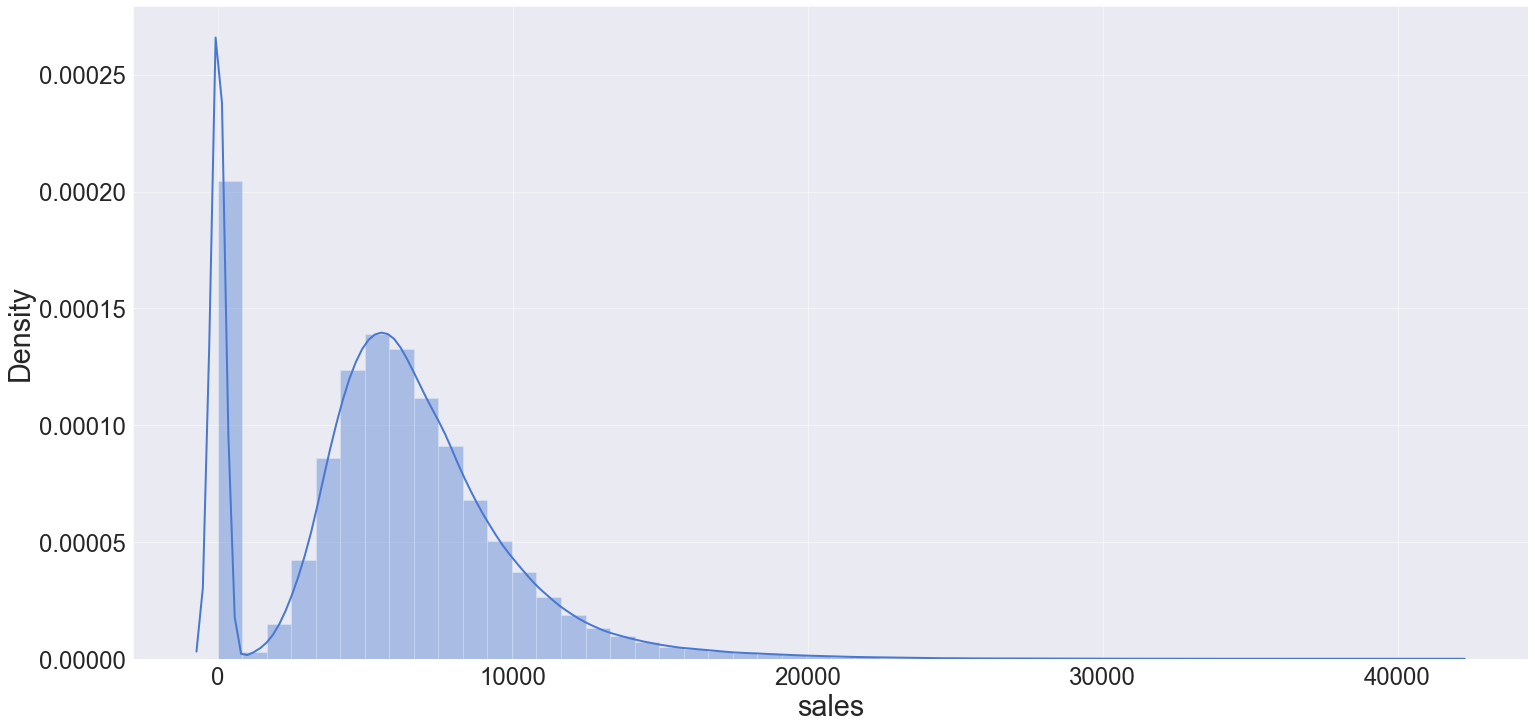

In [33]:
# plots distribution
sns.distplot(df1['sales'])
plt.show()

### 2.7.2. Categorical Attributes

We can get the total count for each unique attribute of these features.

In [43]:
# Qtd. of unique attributes per feature
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

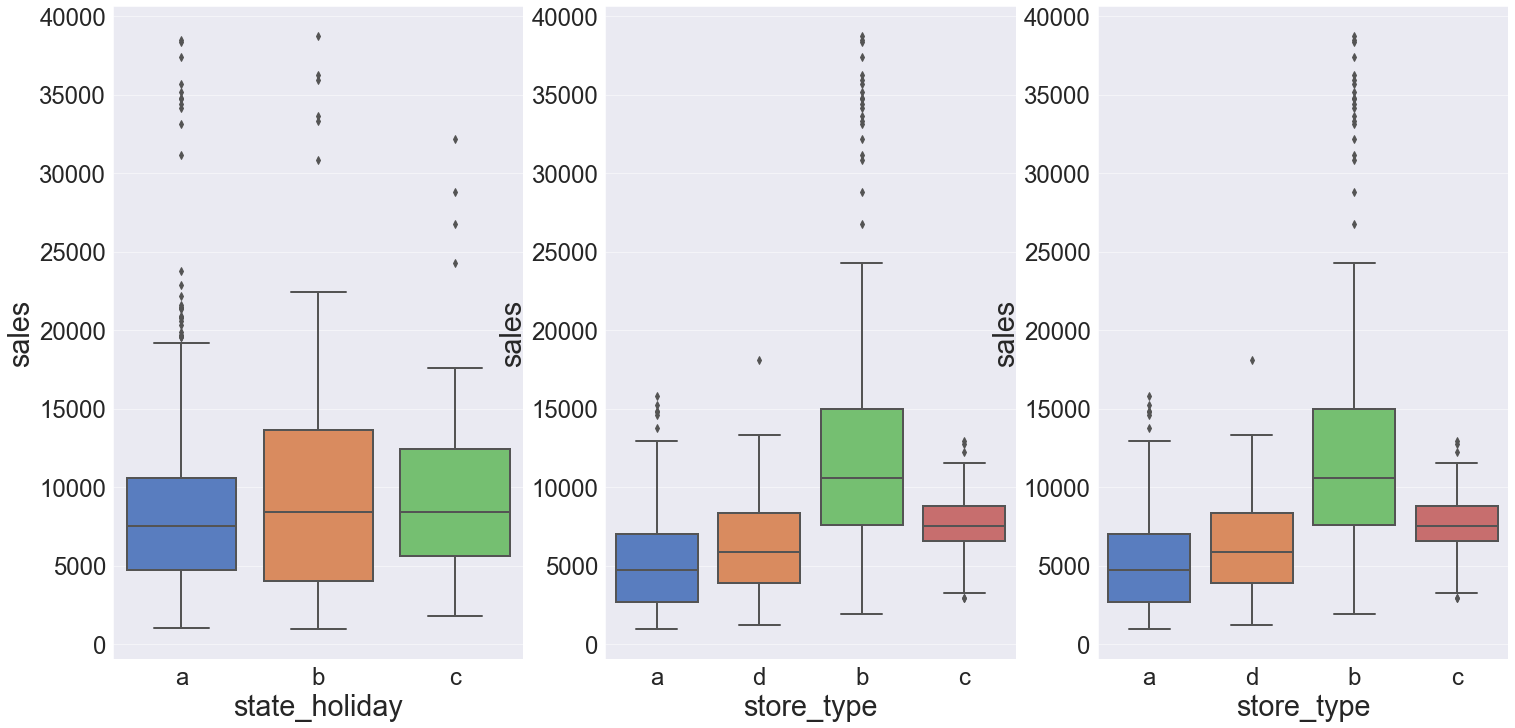

In [48]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

fig, axes = plt.subplots(1, 3)

_ = sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1, ax = axes[0])
_ = plt.subplot(1,3,2)
_ = sns.boxplot(x = 'store_type', y = 'sales', data = aux1, ax = axes[1])
_ = plt.subplot(1,3,3)
_ = sns.boxplot(x = 'store_type', y = 'sales', data = aux1, ax = axes[2])

plt.show()